<a href="https://colab.research.google.com/github/hyejeong1111/Machinelearning/blob/main/%EA%B3%A0%EA%B0%9D_%ED%96%89%EB%8F%99_%EC%98%88%EC%B8%A1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 연구 목표 수립

- 고객 데이터를 분석해서, 이 고객이 다음달에 얼마큼 우리 서비스를 이용할지 예측하시오
- 목표
  - 이를 위한 예측 모델 구축
- 산출물
  - 기획서, 연구절차등등..

# 데이터 수집/획득

- 제공 받아서 진행
  - 가정) 특정 회사내에서 진행되는 프로젝트로 데이터를 제공받았다
  - level 1 사내 데이터 활용
    - customer_join.csv
      - 고객 정보
    - use_log.csv
      - 이용 로그

# 데이터 준비/전처리

In [ ]:
import numpy as np
import pandas as pd

## 데이터 로드 및 기본 체크

In [ ]:
useLog = pd.read_csv('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/0515/use_log.csv')
useLog.shape

(197428, 3)

In [ ]:
# 샘플링 데이터 확인
useLog.head(2)
# 로그아이디, 고객아이디, 로그가 생성된 시간정보 => 고객 사이트(가정)에서 활동한
# 모든 내용중 날짜만 기록했다

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01


In [ ]:
# 결측확인 -> 없음 확인
useLog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [ ]:
# 회원 정보 로드
customer = pd.read_csv('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/0515/customer_join.csv')
customer.head(2)

# 회원탈퇴가 진행되면 end_date가 세팅된다 그전에는 NaN
# mean	median	max	min	=>월 사용량에 대한 평균,...최소값
# membership_period => 회원으로 유지한 기간

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47


In [ ]:
customer.is_deleted.unique()
# 0 현재회원, 1 탈퇴회원

array([0, 1])

In [ ]:
# 회원수 , 컬럼 18개
customer.shape

(4192, 18)

In [ ]:
# 결측 체크 -> end_date 컬럼에서 대량의 결측치 예상
customer.isnull().sum()
# 4192명의 회원중 2842명을 제외하고 모두 탈퇴

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [ ]:
# 67.8% 회원이 탈퇴했다
(2842 / customer.shape[0])*100

67.79580152671755

## 클러스터링으로 회원 그룹화


- 회원을 특정 유형으로 분류할수가 없다 -> 군집화 하여 분류를 하자(머신러닝>비지도학습>군집)
- 유형 분류 -> 이용횟수를 예측할수 있다
  - 컬럼값 a가 x, b가 y,... 인 고객은 다음달 이용횟수 z회이다 <- 예측
- 현재 받은 데이터는 고객유형 정보가 없다

In [ ]:
customer.head(1)

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47


In [ ]:
# 군집화를 위해서 어떤 컬럼을 사용할 것인가? => 수치 중심으로 진행(아이디어)
# 컬럼 중에 필요한것만 추출해서 진행 -> 수치 중심으로 진행
# 인사이트 정보가 없어서 짐작만 할뿐 정확한 컬럼의 의미를 모른다
# 월평균값, 월중앙값, 월최대값, 월최소값, 회원기간
customer_clustering_raw = customer[ ['mean','median','max','min','membership_period'] ]
customer_clustering_raw.head(2)

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47


In [ ]:
customer_clustering_raw.describe()
# std를 보고 데이터의 퍼진 정도를(분포를 체크할수 있다,시각화도 필요)
# 수치들이 많이 퍼져있다 -> 학습시 좋은 성과를 낼수 없다 -> 정규화 처리를 진행
# 0 ~ 1 사이로 데이터를 재분배 처리

,mean,median,max,min,membership_period
count,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269,18.835878
std,1.777533,1.874874,2.168959,1.951565,13.848148
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000,7.000000
50%,5.000000,5.000000,8.000000,3.000000,15.000000
75%,6.416667,6.500000,9.000000,4.000000,30.000000
max,12.000000,12.000000,14.000000,12.000000,47.000000


## 데이터 분포를 확인해 보자

- 산포도(산점도)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
customer_clustering_raw['mean']
customer_clustering_raw.shape

(4192, 5)

In [ ]:
customer_clustering_raw.columns[0]

'mean'

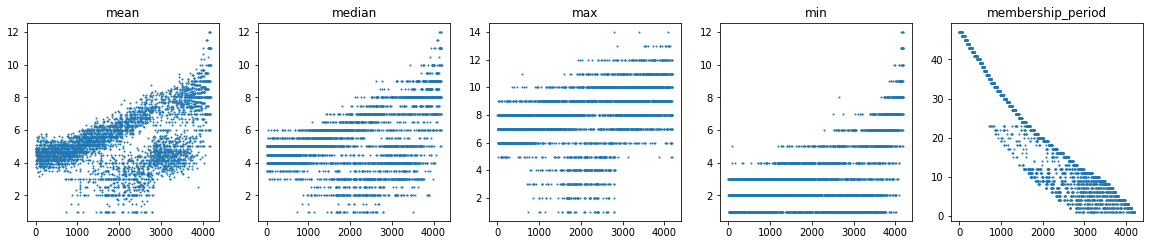

In [ ]:
# 함수 형태로 산포도 구성
# 가로 한줄에 5개의 컬럼 데이터 별로 시각화 수행
def showData( data ):
  plt.figure( figsize=(20,8) )
  X = np.arange( data.shape[0] ) # 0<= X <4192
  cols = customer_clustering_raw.columns
  for i in range(5): # 0 <= i < 5
    plt.subplot( 2, 5, (i+1) )
    plt.scatter( X, data[cols[i]], s=1) # s:데이터 포인트의 크기
    #plt.scatter( X, data[:, i], s=1) # 펜시인덱싱
    plt.title( cols[i] )

def showData2( data ):
  plt.figure( figsize=(20,8) )
  X = np.arange( data.shape[0] ) # 0<= X <4192
  cols = customer_clustering_raw.columns
  for i in range(5): # 0 <= i < 5
    plt.subplot( 2, 5, (i+1) )
    #plt.scatter( X, data[cols[i]], s=1) # s:데이터 포인트의 크기
    plt.scatter( X, data[:, i], s=1) # 펜시인덱싱
    plt.title( cols[i] )


showData( customer_clustering_raw )
# 현재 제공받은 데이터의 분포도를 컬럼별로 확인했다
# 평균은 다양하게 분포되었는데 나머지 컬럼은 동일한 값을 가진 데이터가 많다(수평선이 많이 보임)

In [ ]:
# 전처리기 도입 => 데이터를 조정
# sklearn => 머신러닝 라이브러리를 제공하는 패키지
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

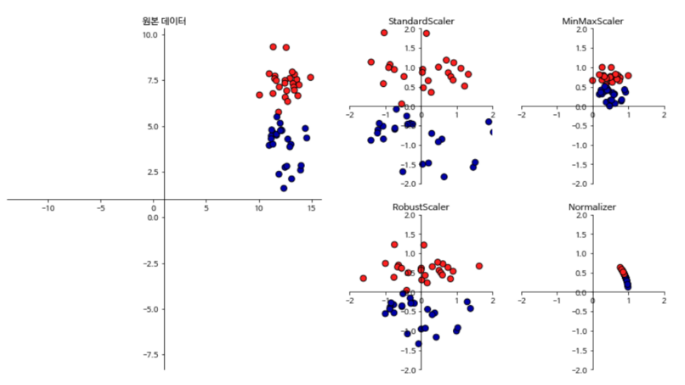

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/res3/스케일링.png')

In [ ]:
# 1. 스케일러 생성
sc = StandardScaler()
# 기존 평균을 제거, 주어진 분산값에 맞게 스케일링 진행, 주로 사용되는 값 1

In [ ]:
# 2. 스케일링(기존데이터를 넣어서 새로운 데이터를 획득)
# 전처러기를 통해서 데이터를 처리하면 전체 데이터가 용도에 맞게 조정된다
customer_clustering_raw_ss = sc.fit_transform( customer_clustering_raw )
customer_clustering_raw_ss

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [ ]:
customer_clustering_raw_ss.shape

(4192, 5)

In [ ]:
# 컬럼별로 std를 획득해 보면 -> 전부 1로 조정되었다 (표준편차, 분산)
customer_clustering_raw_ss.std(axis = 0)

array([1., 1., 1., 1., 1.])

In [ ]:
customer_clustering_raw.describe()
# 1.777533	1.874874	2.168959	1.951565	13.848148 => 1 1 1 1 1

,mean,median,max,min,membership_period
count,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269,18.835878
std,1.777533,1.874874,2.168959,1.951565,13.848148
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000,7.000000
50%,5.000000,5.000000,8.000000,3.000000,15.000000
75%,6.416667,6.500000,9.000000,4.000000,30.000000
max,12.000000,12.000000,14.000000,12.000000,47.000000


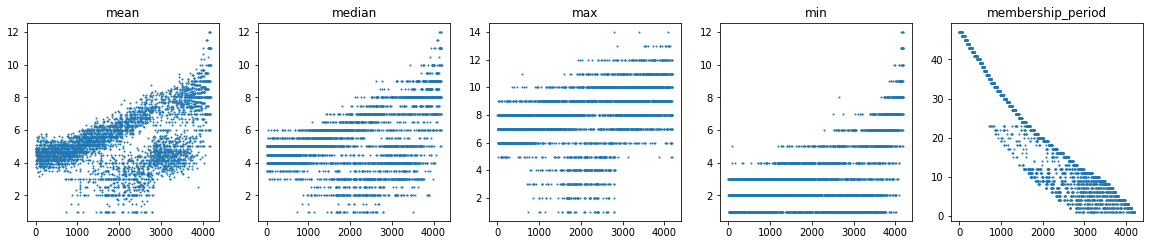

In [ ]:
showData( customer_clustering_raw )
# 원본 데이터

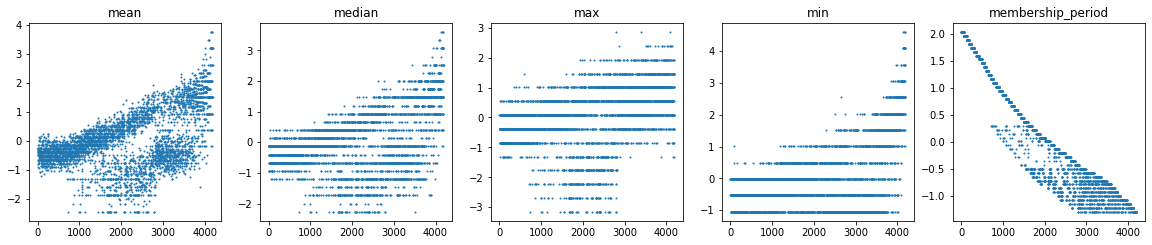

In [ ]:
showData2( customer_clustering_raw_ss )
# 데이터 포인트들을 StandardScaler로 스케일링 한 후 산포도 -> y축 기준 체크
# 전체적인 분포 형태는 동일, 값의 분포도를  std 1로 맞춰서 조정 -> 예측정확도를 높이기 위해

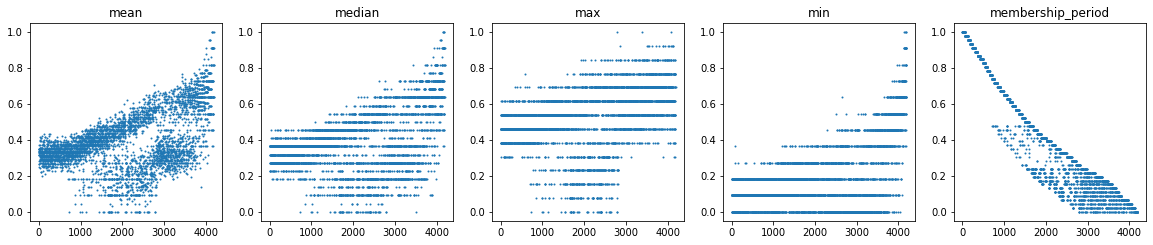

In [ ]:
scaler = MinMaxScaler()
# 데이터 중 가장 작은값을 0, 큰값을 1로 넣고 나미저 데이터 조정
showData2( scaler.fit_transform(customer_clustering_raw) )
# y축은 모두 0.0 ~ 1.0으로 조정되었다

In [ ]:
scaler.fit_transform(customer_clustering_raw).std(axis = 0)
# 대부분 0.5 이하로 std가 조정되었다

array([0.16157466, 0.17042273, 0.16682312, 0.1773938 , 0.30101078])

- 데이터 정규화 처리
  - 목표 : 예측 정확도(모델의 성능)을 높이기 위해서 데이터를 스케일링 하는 전략
  - 특징
    - 통상적으로 0 ~1 사이로 데이터가 분포되면 학습 성과가 좋다고 평가된다
    - 표준편차, 분산등의 값을 조정하는 것도 중요
    - 예측 모델의 정확도를 높이기 위해서 다양하게 전처기리를 사용하고, 가장 높은 스코어를 가진 전처기를 사용한다 -> 교차검증, 하이퍼퍼라미터튜닝, 파이프라인구축

- 현재는 customer_clustering_raw_ss를 사용하겠다

## 군집화

- 고객의 이용 횟수(다음달)을 예측하기 위해서 고객 유형화(군집화, 클러스터링) 필요
- 알고리즘
  - 거리기반, 밀도기반, 확률기반,...
- 여기서는 거리기반 군집 알고리즘
  - k-means 사용

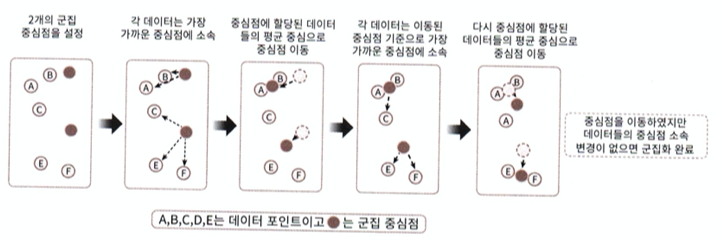

In [ ]:
Image('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/res3/k-mean_0.png')

# 1. A,B,C,..F 데이터 포인트 분포도
# 2. 데이터 포인트 분포도 사이에 임의의 2개의 중심점이 찍혔다(첫번째 그림)
#    중심점(랜덤, 최초 데이터를 분석해서 밀도가 높은곳에 찍을수도 있다)
#          2개를 찍은 것은 설정
# 3. 중심점 기준으로 가장 가까은 데이터 포인트들은 그 중심점에 소속된다
# 4. 그렇게 모여있는 그룹에 평균 중심에 중심점이 이동한다
# 5. 새로운 중심점에서 다시 소속을 정리
# 6. 정해진 회수만큼 반복하여서 군집을 종료시킨다. 혹은 더이상 중심점 이동이 없으면 종료

In [ ]:
# 머신러닝 알고리즘 sklearn
# https://scikit-learn.org/stable/
from sklearn.cluster import KMeans

In [ ]:
# 머신러닝 알고리즘은 1차 핵심 => 역할(의미), 파라미터, 사용법
# 1. 사용하는법등 사용에 익숙해지는게 1차 목표
# 2. 익숙해 지면 그 원리에 집중(심화)

# n_clusters=8 : 군집 중심점의 개수 => 군집의 개수
# 여기서는 고객을 4개의 유형(그룹)으로 묶겟다 -> 심화로 가면 몇개의 군집이 정확한지 군집평가 수행
kmeans = KMeans(n_clusters=4, random_state=0)

In [ ]:
# 데이터 포인트를 넣고 군집 학습(비지도) 진행
clusers = kmeans.fit( customer_clustering_raw_ss )

In [ ]:
# 군집 결과, 특정 데이터는 어떠 그룹에 속하는지 표기
clusers.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
# 파생변수로 군집 결과를 추가
customer_clustering_raw['cluser'] = clusers.labels_

customer_clustering_raw['cluser'].unique()
# 4개 그룹으로 고객을 분류했다

array([1, 2, 3, 0], dtype=int32)

In [ ]:
customer_clustering_raw.head(2)

,mean,median,max,min,membership_period,cluser
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1


In [ ]:
# 컬럼명 변경
customer_clustering_raw.columns = ['월평균','월중앙','월최대','월최소','회원기간','cluster']
customer_clustering_raw.head(1)

,월평균,월중앙,월최대,월최소,회원기간,cluster
0,4.833333,5.0,8,2,47,1


In [ ]:
customer_clustering_raw.groupby('cluster').count()
# 각 그룹별 카운트 확인

,월평균,월중앙,월최대,월최소,회원기간
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


## 군집 평가-> 차원축소를 활용하여 시각화 확인

- 잘 군집화 되었는지 시각적으로 확인
- 일반적인 군집평가 기법을 사용하지 않고 , 차원축소로 피처를 2개로 줄이고 이를 시각화하여 군집별로 잘 구분되었는지 확인
- PCA
  - 여러 변수들 간의 존재하는 상관관계를 이용
  - 이들을 대표하는 주성분을 추출하여 차원을 축소한다

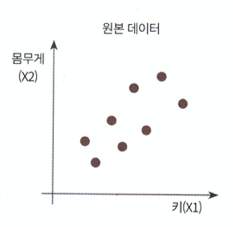

In [ ]:
Image('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/res3/pca_1.png')
# 원본 데이터의 분포도 (산포도)

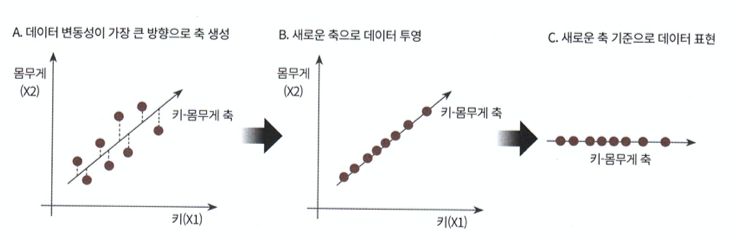

In [ ]:
Image('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/res3/pca_2.png')
# PCA 진행 절차(러프하게 표현)

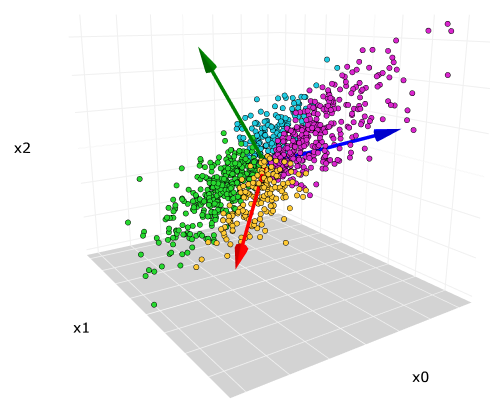

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/res3/pca_3.png')

# 1. 데이터 분포상 가장 변동성이 큰 방향으로 첫번째 축(백터축)을 생성
# 2. 두번째축은 첫번째 축에 직교 백터(직각이 되는 백터)를 생성
# 3. 세번째축은 두번째 축과 직각이 되는 백터를 구해서, 이 축에 데이터를 모두 투영한다
# 4. 차원이 축소되어서 피처수가 줄어든다

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature를 2개로 압축하겠다
pca = PCA(n_components=2)

In [ ]:
# 원본데이터 -> 스케일링 처리 -> 압축을 위한 훈련
pca.fit( customer_clustering_raw_ss )

PCA(n_components=2)

In [ ]:
# 압축하여 feature 2개 획득
x_pca = pca.transform( customer_clustering_raw_ss )

In [ ]:
# df 구성
pca_df = pd.DataFrame( x_pca )
pca_df.head(1)

,0,1
0,-0.819982,-1.959097


In [ ]:
pca_df['cluster'] = clusers.labels_
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1


In [ ]:
pca_df.shape
# feature 2개는 압축한결과, 1개는 군집번호
# feature 2개는 cluster 값을 결정하는 샘플 -> 시각화

(4192, 3)

In [ ]:
pca_df.cluster.unique()

array([1, 2, 3, 0], dtype=int32)

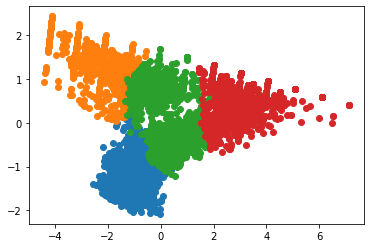

In [ ]:
# 군집별로 산포도를 그린다 -> 군집변로 다른 색상의 포인트가 등장
for i in pca_df.cluster.unique():
  #print( i )
  # 1. 해당 그룹번호와 일치하는 데이터만, 추출
  tmp = pca_df.loc[ pca_df.cluster == i ]
  # 2. 산포도 그리기
  plt.scatter( tmp[0], tmp[1] )

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

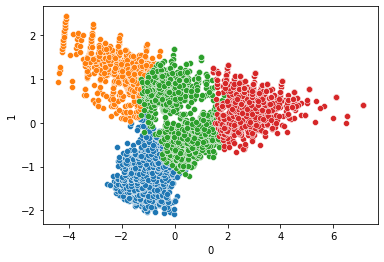

In [ ]:
import seaborn as sns
for i in pca_df.cluster.unique():
  tmp = pca_df.loc[ pca_df.cluster == i ]
  sns.scatterplot ( tmp[0], tmp[1] )

plt.show()

- 데이터 분포도를 그룹별로 시각회 해보니 그룹별로 잘 구분(분류)이 되었다
- 이를 통해서 데이터를 잘 그룹화 했다

# 데이터 분석

- 성향 분석
  - 탈퇴 회원들의 경향 파악

In [ ]:
customer_clustering_raw.head(1)

,월평균,월중앙,월최대,월최소,회원기간,cluster
0,4.833333,5.0,8,2,47,1


In [ ]:
customer.head(1)

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47


In [ ]:
customer_clustering_raw.shape, customer.shape
# 데이터 개수 동일, 순서도 동일

((4192, 6), (4192, 18))

In [ ]:
# 합병 -> customer_clustering_raw, customer 이 순서대로 단순 합치기
customer_clustering = pd.concat( [customer_clustering_raw, customer], axis=1 )
customer_clustering.shape

(4192, 24)

In [ ]:
customer_clustering.head(1)

,월평균,월중앙,월최대,월최소,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,4.833333,5.0,8,2,47,1,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47


In [ ]:
customer_clustering.columns

Index(['월평균', '월중앙', '월최대', '월최소', '회원기간', 'cluster', 'customer_id', 'name',
       'class', 'gender', 'start_date', 'end_date', 'campaign_id',
       'is_deleted', 'class_name', 'price', 'campaign_name', 'mean', 'median',
       'max', 'min', 'routine_flg', 'calc_date', 'membership_period'],
      dtype='object')

In [ ]:
# 탈퇴 -> end_date, is_deleted (0:유지, 1:탈퇴)
# 그룹바이의 대사 => [그룹별, 탈퇴여부별 ] -> 인덱스가 2레벨로 구성
customer_clustering.groupby( ['cluster','is_deleted'] ).count()

# 2번 그룹은 모두 탈퇴한 회원이다 -> 특정 이벤트때 가입후 이벤트 종료후 탈퇴한것?
# 3번 그룹은 60%는 유지, 40% 탙퇴
# 0,1번 그룹은 대부분의 회원들이 유지

월평균   월중앙   월최대   월최소  회원기간  customer_id  name  class  \
cluster is_deleted                                                           
0       0            821   821   821   821   821          821   821    821   
        1             19    19    19    19    19           19    19     19   
1       0           1231  1231  1231  1231  1231         1231  1231   1231   
        1             18    18    18    18    18           18    18     18   
2       1            771   771   771   771   771          771   771    771   
3       0            790   790   790   790   790          790   790    790   
        1            542   542   542   542   542          542   542    542   

                    gender  start_date  ...  class_name  price  campaign_name  \
cluster is_deleted                      ...                                     
0       0              821         821  ...         821    821            821   
        1               19          19  ...          19     19             19   
1       0             1231        1231  ...        1231   1231           1231   
        1               18          18  ...          18     18             18   
2       1              771         771  ...         771    771            771   
3       0              790         790  ...         790    790            790   
        1              542         542  ...         542    542            542   

                    mean  median   max   min  routine_flg  calc_date  \
cluster is_deleted                                                     
0       0            821     821   821   821          821        821   
        1             19      19    19    19           19         19   
1       0           1231    1231  1231  1231         1231       1231   
        1             18      18    18    18           18         18   
2       1            771     771   771   771          771        771   
3       0            790     790   790   790          790        790   
        1            542     542   542   542          542        542   

                    membership_period  
cluster is_deleted                     
0       0                         821  
        1                          19  
1       0                        1231  
        1                          18  
2       1                         771  
3       0                         790  
        1                         542  

[7 rows x 22 columns]

In [ ]:
# 인덱스 별도 구성, 기존 인덱스는 데이터를 포함
customer_clustering.groupby( ['cluster','is_deleted'], as_index=False ).count()

,cluster,is_deleted,월평균,월중앙,월최대,월최소,회원기간,customer_id,name,class,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,0,0,821,821,821,821,821,821,821,821,...,821,821,821,821,821,821,821,821,821,821
1,0,1,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
2,1,0,1231,1231,1231,1231,1231,1231,1231,1231,...,1231,1231,1231,1231,1231,1231,1231,1231,1231,1231
3,1,1,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
4,2,1,771,771,771,771,771,771,771,771,...,771,771,771,771,771,771,771,771,771,771
5,3,0,790,790,790,790,790,790,790,790,...,790,790,790,790,790,790,790,790,790,790
6,3,1,542,542,542,542,542,542,542,542,...,542,542,542,542,542,542,542,542,542,542


In [ ]:
# 필요한 정보만 둔다
df = customer_clustering.groupby( ['cluster','is_deleted'], as_index=False ).count()

In [ ]:
# customer_id가 아니더라도, 다른 컬럼도 상관없음
df[ ['cluster','is_deleted','customer_id'] ]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


- 각 그룹별 특성을 확인했음
- 각 특성에 대한 분석은 별도로 진행하지 않았다

In [ ]:
# useLog를 이용하여 -> 날짜 정보가 존재 => 월별 집계 -> 이를 기준으로 예측 가능한 데이터 구조 생성
useLog.head(2)

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01


In [ ]:
# 실습 2분 -> 컬럼명 '년월' 데이터 추가 -> ex) 201804
useLog['usedate'].dtype
useLog['usedate'] = pd.to_datetime( useLog['usedate'] )
useLog['usedate'].dtype

dtype('<M8[ns]')

In [ ]:
# 월단위로 데이터를 표현
useLog['년월'] = useLog['usedate'].dt.strftime('%Y%m')
useLog.head(2)

,log_id,customer_id,usedate,년월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804


In [ ]:
useLog['년월'].unique()
# 총 12개(12개월치)를 제공->
# 1월 ~ 6월 => 7월 예측
# 2월 ~ 7월 => 8월 예측
# ...=> 총 6개의 데이터가 생성된다

array(['201804', '201805', '201806', '201807', '201808', '201809',
       '201810', '201811', '201812', '201901', '201902', '201903'],
      dtype=object)

In [ ]:
# 년월, 고객별 사용횟수 집계
useLog_months = useLog.groupby(['년월','customer_id'], as_index=False).count()
useLog_months
# log_id,	usedate => 중복적, 의미도 컬럼명과 다름

,년월,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [ ]:
# 특정 컬럼명 변경,
useLog_months.rename( columns={'log_id':'count'}, inplace=True)

In [ ]:
# 불필요한 컬럼 제거
del useLog_months['usedate']

In [ ]:
useLog_months.head(1)

,년월,customer_id,count
0,201804,AS002855,4


## 예측에 사용할 데이터 준비

In [ ]:
# 1. 비워있는 df 구성
data = pd.DataFrame()
data
# 데이터를 나중에 채우겟다
# 데이터는 앞에 6개월치 데이터를 학습하고 다음달 데이터를 정답으로 사용한 형태를 활용
# 궁극적으로는 데이터가 부족한것은 사실

""


In [ ]:
# 7개월차에 해당되는 년월 확인, 4월부터 출발하는 데이터이므로
useLog_months['년월'].unique(), useLog_months['년월'].unique()[6]
# '201804', '201805', '201806', '201807', '201808', '201809' => '201810'

(array(['201804', '201805', '201806', '201807', '201808', '201809',
        '201810', '201811', '201812', '201901', '201902', '201903'],
       dtype=object), '201810')

In [ ]:
year_month = useLog_months['년월'].unique()
year_month

array(['201804', '201805', '201806', '201807', '201808', '201809',
       '201810', '201811', '201812', '201901', '201902', '201903'],
      dtype=object)

In [ ]:
for i in range( 6, year_month.shape[0] ): # 6 <= i < 12 : 년월 정보를 획득하는 인덱스
  #print( i )
  # 1. 해당 인덱스와 일치하는(년월 일치) 데이터만,  추출 => 블리언 인덱싱 => 다음달예측값
  tmp = useLog_months.loc[ useLog_months['년월'] == year_month[i] ]
  #print( tmp )
  # 2. 이 데이터는 앞선 6개월치 데이터의 예측값이다 -> 정답데이터 -> 종속변수
  tmp.rename( columns={'count':'pred_count'}, inplace=True )
  #display( tmp )
  # 3. 기준월에서 이전 6개월치 데이터를 준비 -> 피처데이터 -> 독립변수
  for j in range( 1, 7 ): # 1 <= j < 7
    # 4. 직전월(j=1) -> 전전월(j=2) -> ... -> 마지막월(j=6)
    # 6-1, 6-2, 6-3, ...6-6
    # 7-1, 7-2,...... 7-6
    before_month = useLog_months.loc[ useLog_months['년월'] == year_month[i-j] ]
    # 5. 중복되는 컬럼중 년월 -> 제거
    del before_month['년월']
    # 6. count -> count_회차표현, count_0, count_1,...
    before_month.rename( columns={'count':'count_{}'.format(j-1)}, inplace=True )
    # 7. tmp에 before_month를 머지
    tmp = pd.merge( tmp, before_month, on='customer_id', how='left' )
    #break

  # 8. 비어있는 data에 tmp을 추가한다
  data = pd.concat( [data, tmp], ignore_index=True )

data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [ ]:
data.shape

(18310, 9)

## 결측 데이터 처리

- 제거/삭제하기(deletion)
  - 결측치의 특성이 무작위(랜덤) 손실이 아니라면, 삭제가 가장 베스트 처리
  - 방법
    - 목록 삭제
      - 결측치 전체 행 삭제(가로한줄)
    - 쌍 삭제
      - 해당값 무시
  - 특징
    - 정보손실 발생, 케이스별로 적용 불가일수도 있다

- 채우기/보간하기(imputation)
  - 자주 사용하는 평균화 기법(populator Averageing ..)
    - 평균, 중앙값등등 이용하여 유추
    - 통계값에 영향을 미친다
  - 예측기법(predictive ..)
    - 패턴을 학습해서, 회귀분석을 통해 결측을 채운다  

In [ ]:
# 결측 데이터 처리 > 제거/삭제하기(deletion) > 목록 삭제
# 결측이 있는 데이터는 모두 제거
data = data.dropna()
data.shape, display(data)
# 정보손실발생, 데이터는 클린해짐, 인덱스가 무너짐

,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
5,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
7,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
18304,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


((15113, 9), None)

In [ ]:
# 인덱스 정렬
data = data.reset_index()
data.head()

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5
0,0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,5,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,7,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [ ]:
customer.head(1)

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47


## 예측에 필요한 데이터 생성

In [ ]:
# 현데이터에 필요한 정보를 고객 정보에서 획득해서 추가
# 가입일 => start_date
# 실습 4분 => data에 customer의 start_date 컬럼 및 데이터를 추가하시오 => merge()
predict_data = pd.merge( data, customer[['customer_id','start_date']],
                         on = 'customer_id', how='left' )
predict_data.head(2)

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01


In [ ]:
# 가입입, 기준월일을 이용하면 -> 해당 데이터 기준으로한 가입기간 정보 계산
# 월데이터를 기준으로 현재 기준일 컬럼 추가 => now_date
# 월기준이므로 -> 일정보가 없다 -> 1일로 세팅
predict_data['now_date']   = pd.to_datetime( predict_data['년월'],format='%Y%m' )
predict_data['start_date'] = pd.to_datetime( predict_data['start_date'] )
predict_data.head(1)

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date
0,0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01


In [ ]:
predict_data.tail(1)

NameError: ignored

In [ ]:
predict_data.shape

(15113, 12)

In [ ]:
# 현재 날짜 기준에서 가입일가지 기간 계산
from dateutil.relativedelta import relativedelta

In [ ]:
predict_data['preiod'] = None
predict_data.head(1)

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,preiod
0,0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,None


In [ ]:
# 모든 데이터를 돌면서, 기간계산
for i in range( predict_data.shape[0] ): # 0 ~ 15113-1
  # 1. 기간계산 => years, months 만 나온다 => 기간(몇 개월차) => 월단위로 통합
  value = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
  # 2. 데이터 업데이트
  predict_data['preiod'][i] = value.months + value.years*12
  #print( value.months, value.years )
  #break
  #pass

predict_data.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,preiod
0,0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23


In [ ]:
predict_data.tail(1)

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,preiod
15112,18309,201903,TS999855,4,4.0,7.0,5.0,4.0,4.0,5.0,2017-04-01,2019-03-01,23


# 모델 구축

- 이 예측 모델은 분류 혹은 회귀의 문제인가?
  - 분류는 이것은 저것이다 (범주형값 지정)
  - 회귀는 이것은 수치로 예측된다 (연속형값 지정)
- 고객 행동 예측(다음달에 특정 고객은 몇번 이용할것인가?) 문제는 회귀의 문제로 확인되며, 회귀 알고리즘을 이용하여서 예측모델을 구축, 학습, 예측을 수행한다
- 이 고객은 다음달에 3.245회 이용할것으로 예측된다

- 머신러닝 절차
  - 모델 선정
  - 데이터 준비
  - 훈련
  - 예측 및 평가
  - 최적화
    - 하이퍼 파라미터 튜닝
    - 교차 검증
    - 파이프라인
  - 성능평가
  - 최적의 모델 선정, 최적의 파라미터, 파이프라인등을 선정

## 모델 선정

- 알고리즘 설정

In [ ]:
# 단순 선형 회귀를 이용하겠다 => 알고리즘 종류는 신경 않쓴다
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# 모델 생성
model = LinearRegression()

## 데이터 준비

In [ ]:
predict_data.shape

(15113, 13)

In [ ]:
# 1. 만약, 가입일 2018년도 4월 1일 이상인 유저만 대상으로 진행된다면
# 특정 타겟 회원을 대상으로 예측 모델 구성이 가능하다
target_df = predict_data.loc[ predict_data['start_date']>= pd.to_datetime('20180401') ]
target_df.head(2)

,index,년월,customer_id,pred_count,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,preiod
49,67,201810,AS185951,1,5.0,3.0,3.0,7.0,3.0,10.0,2018-04-09,2018-10-01,5
55,74,201810,AS197200,12,6.0,8.0,9.0,6.0,8.0,8.0,2018-04-15,2018-10-01,5


In [ ]:
target_df.shape

(1702, 13)

In [ ]:
# 2. 필요한 데이터만 추출
#    -> 수치, 독립적인 데이터(독립변수 사이에 상관성이 존재하면 해당 변수는 제거)
X = target_df[ ['count_0','count_1','count_2','count_3','count_4','count_5','preiod' ] ]
X

,count_0,count_1,count_2,count_3,count_4,count_5,preiod
49,5.0,3.0,3.0,7.0,3.0,10.0,5
55,6.0,8.0,9.0,6.0,8.0,8.0,5
56,6.0,3.0,6.0,6.0,7.0,10.0,5
72,4.0,6.0,5.0,8.0,10.0,7.0,5
96,3.0,5.0,6.0,5.0,4.0,7.0,5
...,...,...,...,...,...,...,...
15097,8.0,5.0,6.0,9.0,8.0,8.0,9
15103,8.0,6.0,7.0,5.0,8.0,8.0,10
15104,10.0,7.0,6.0,10.0,8.0,6.0,7
15106,10.0,10.0,9.0,8.0,8.0,9.0,5


In [ ]:
y = target_df['pred_count']
y

49        1
55       12
56        3
72        2
96        1
         ..
15097     7
15103     7
15104     7
15106    10
15109     8
Name: pred_count, Length: 1702, dtype: int64

In [ ]:
# X : Dataframe, y : Series
# X와 y사이에는 1차원의 갭이 존재함

In [ ]:
# 3. 훈련용, 테스트용 데이터를 분류( 75:25 <- 통상적인 황금비율, 절대적이지 않음 )
# 기본값이 75 : 25
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1276, 7), (426, 7), (1276,), (426,))

## 훈련

In [ ]:
# 전체 데이터의 75%을 가지고 훈련 진행
model.fit(X_train, y_train)

LinearRegression()

## 예측 및 평가

In [ ]:
model.score( X_test, y_test )
# 정확도 61.8% -> 이런 데이터를 가지고 90%이상 정확도를 높이시오!!
# 1. 데이터를 늘린다

0.6187279886826293

## 최적화 (생략)

- 정확도 상승

## 성능평가(생략)

- 회귀 -> 손실값, 각종 지표 체크

## 기타

In [ ]:
X.columns, len( X.columns)

(Index(['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5',
        'preiod'],
       dtype='object'), 7)

In [ ]:
# 모델에 기여하는 변수 체크
model.coef_, len( model.coef_)

(array([0.33874536, 0.17193228, 0.19573506, 0.1815119 , 0.05387712,
        0.07925657, 0.07890485]), 7)

In [ ]:
coef = pd.DataFrame( {'컬럼명':X.columns, '기여도':model.coef_} )
coef

,컬럼명,기여도
0,count_0,0.338745
1,count_1,0.171932
2,count_2,0.195735
3,count_3,0.181512
4,count_4,0.053877
5,count_5,0.079257
6,preiod,0.078905


## 결론

In [ ]:
# 다음 달의 이용 횟수를 예측 -> 해당 유저는 7개의 정보가 필요
# 유저 x1, x2
x1 = [3,4,5,2,6,7,20]
x2 = [1,4,6,2,3,3,8]

In [ ]:
x_predict_data = [ x1, x2 ]
x_predict_data

[[3, 4, 5, 2, 6, 7, 20], [1, 4, 6, 2, 3, 3, 8]]

In [ ]:
# 예측 -> 다음달에 몇번을 이용하지?
model.predict( x_predict_data )
# x1 -> 4.07회 이용으로 예상된다
# x2 -> 2.17회 이용으로 예상된다
# 단, 정확도가 61.8%이다

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([4.0773722 , 2.17010074])

In [ ]:
# 이 정확도를 최대한 높여라 -> 95%까지 도달하시오!!
# 전체데이터에서 12%만 사용했다 -> 전체 데이터를 사용하여 동일하게 학습후 정확도를 뽑아보시오
# 다음 시간 10분정도 진행->같이 진행